In [34]:
%display latex
from utils import *

The modified update rule does not use a negative for the other indices.
$$
  x_i = 
  \begin{cases}
    \frac{1}{x_i}, & \text{ if } i = \ell, \\
    \frac{x_i}{x_\ell}, & \text{ otherwise.} \\
  \end{cases}
$$

In [36]:
x = var('x')
K.<alpha> = NumberField(x^2 - x - 1, embedding=RR(1))
xs = (alpha,)
ys = get_convergent(xs, [0, 0])
matrix([(yi.denominator() * abs(xi - yi)).list() for xi, yi in zip(xs, ys)])

[-3  2]

In [39]:
K.<alpha> = NumberField(x^3 - 2, embedding=RR(1))
xs = (alpha, alpha^2)
ys = pivot(xs, 0, 1, 0, 1, 0, 1, 0, 1)
matrix([yi.list() for yi in ys]).T

[2 1]
[1 1]
[0 1]

In [41]:
x = var('x')
rows = []
K.<alpha> = NumberField(x^2 - 6, embedding=RR(1))
y = alpha

[1, alpha]

In [24]:
x = y
a = floor(x)
y = 1/(x-a)
rows.append([a, x.list(), RR(x)])
table(rows)

\(2\),"\(\left[0, 1\right]\)",\(2.44948974278318\)
\(2\),"\(\left[1, \frac{1}{2}\right]\)",\(2.22474487139159\)
\(4\),"\(\left[2, 1\right]\)",\(4.44948974278318\)
\(2\),"\(\left[1, \frac{1}{2}\right]\)",\(2.22474487139159\)
\(4\),"\(\left[2, 1\right]\)",\(4.44948974278318\)
\(2\),"\(\left[1, \frac{1}{2}\right]\)",\(2.22474487139159\)
\(4\),"\(\left[2, 1\right]\)",\(4.44948974278318\)
\(2\),"\(\left[1, \frac{1}{2}\right]\)",\(2.22474487139159\)
\(4\),"\(\left[2, 1\right]\)",\(4.44948974278318\)
\(2\),"\(\left[1, \frac{1}{2}\right]\)",\(2.22474487139159\)
\(4\),"\(\left[2, 1\right]\)",\(4.44948974278318\)


In [31]:
(1/(alpha-2))

1/2*alpha + 1

2.44948974278318

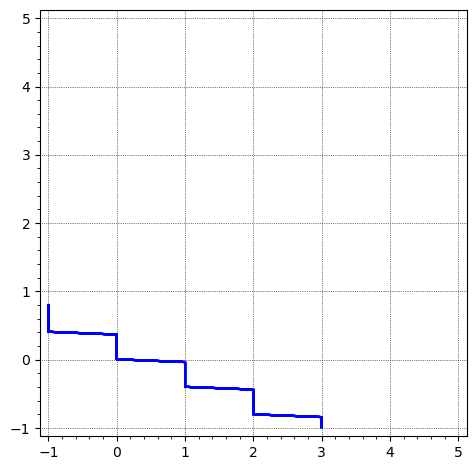

In [11]:
x,y=var('x,y')
pretty_print(RR(alpha))
sum([implicit_plot(x==-floor(alpha*y), (x,-1,5), (y,-1,5), gridlines=True) for i in range(-10, 10)])

# Brute-Force Search

The brute-force search is done in a breadth-first fashion.
We try every list of length $n$ and then every list of length $n + 1$,
until we find a period in the representation.

In [2]:
def brute_force(xs, max_depth, exhaustive=False):
    indices = [0]
    result = None
    d = len(xs)
    while indices:
        init, repeat = get_period(xs, indices[1:])
        is_valid = len(repeat) > 0
        if is_valid:
            if not exhaustive:
                return init, repeat
            if not result:
                result = []
            result.append((init, repeat))
        indices = increment_nary(indices, d, max_depth + 1)
    return result

def brute_force_2d(xs, max_depth, exhaustive=False):
    """
    Faster version which uses an integer to determine the pivot sequence
    """
    
    def get_indices_list(indices_value):
        result = []
        while indices_value > 0:
            if indices_value & 1 != 0:
                result.append(1)
            else:
                result.append(0)
            indices_value >>= 1
        return result[:-1]
        
    indices = 0
    result = None
    d = len(xs)
    while indices < (2 << max_depth):
        init, repeat = get_period(xs, get_indices_list(indices))
        if repeat:
            if not exhaustive:
                return init, repeat
            if not result:
                result = []
            result.append((init, repeat))
        indices += 1
    return result

Here is, for example, the period for $\sqrt[3]{4}$. Notably, this value likely doesn't have a periodic representation in the Jacobi-Perron algorithm. First, the pivots which lead to a period are shown. The period is marked with a line over the pivots. The actual representation of $\sqrt[3]{4}$ is shown in the next block.

In [3]:
d = 2
p = x^3 - 5
K.<alpha> = NumberField(p, embedding=RR(1))

xs = (alpha, alpha^2)
init, repeat = brute_force(xs, 15)
pretty_print(pretty_continued_fraction(init, repeat))
pretty_print(list(zip(list(get_coeffs(xs, init + 2 * repeat)), init + 2 * repeat)))
pretty_print(RR(get_decrease(xs, *init, *repeat)))
pretty_print(RR(alpha))

[0, \overline{0, 0, 1, 1, 1, 0, 0, 0}]

[((1, 2), 0),
 ((1, 2), 0),
 ((1, 1), 0),
 ((2, 0), 1),
 ((2, 1), 1),
 ((0, 1), 1),
 ((0, 1), 0),
 ((0, 1), 0),
 ((1, 0), 0),
 ((3, 0), 0),
 ((1, 1), 0),
 ((2, 0), 1),
 ((2, 1), 1),
 ((0, 1), 1),
 ((0, 1), 0),
 ((0, 1), 0),
 ((1, 0), 0)]

0.00577330410628818

1.70997594667670

In [4]:
from utils import *

xs = (alpha, alpha^2)
indices = init + repeat
coeffs = list(get_coeffs(xs, indices))

rows = []
for i in range(1, len(indices), 2):
    conv = [get_convergent(xs, indices[:i] + [l1, l2]) for l1 in range(d) for l2 in range(d)]
    row = [indices[i-1], indices[i], real_list(pivot(xs, *indices[:i]))]
    row += min([(f'{i:02b}', prod([RR(abs(rj - xj)) for j, xj, rj in zip(range(d), xs, r)])) for i, r in enumerate(conv)], key=lambda e: e[1])
    rows.append(row)

table(rows)

\(0\),\(0\),"\(\left[1.4085, 1.3015\right]\)",11,\(0.0000196253472088237\)
\(0\),\(1\),"\(\left[2.2322, 1.6474\right]\)",00,\(9.66399561805282 \times 10^{-8}\)
\(1\),\(1\),"\(\left[0.6585, 1.836\right]\)",11,\(1.84879517585154 \times 10^{-8}\)
\(0\),\(0\),"\(\left[1.2695, 0.2491\right]\)",11,\(1.29259963904815 \times 10^{-10}\)


In [5]:
indices = []

In [6]:
values = []
i = 0
for l in range(d):
    r = get_convergent(xs, [*indices, l])
    values.append((l, RR(sum([(ri - xi)**2 for ri, xi in zip(r, xs)]))))
l, _ = min(values, key=lambda e: e[1])
indices.append(l)
pretty_print(indices)
get_period(xs, indices)[1]

[0]

[]

In [7]:
ys = xs
rows = []
for i in init + repeat:
    def f(zs):
        return frac(prod([z**d for z in zs]))
    choices = [pivot(ys, l)[0] for l in range(d)]
    row = [zs for l, zs in enumerate(choices)]
    rows.append([i, *ys] + real_list(flatten(row)) + flatten(row))
    ys, _ = pivot(ys, i)

table(rows)

TypeError: object of type 'sage.rings.number_field.number_field_element.NumberFieldElement_absolute' has no len()

Period lengths for the first 28 numbers:

In [ ]:
for i in range(2, 20):
    try:
        K.<alpha> = NumberField(x^(d+1) - i, embedding=RR(1))
        xs = tuple(sum(alpha^j for j in range(1, i + 1)) for i in range(1, d + 1))
        init, repeat = brute_force(xs, 20)[0]
        print(i, len(repeat))
    except KeyboardInterrupt:
        break
    except:
        pass

In [ ]:
K.<alpha> = NumberField(x^2 - 2, embedding=RR(1))
pivot((alpha,), 0, 0, 0, 0, 0, 0)

# Geometric Interpretation of the Continued Fractions

[2; 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1, ...]

[1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 4,
 1,
 1,
 1]

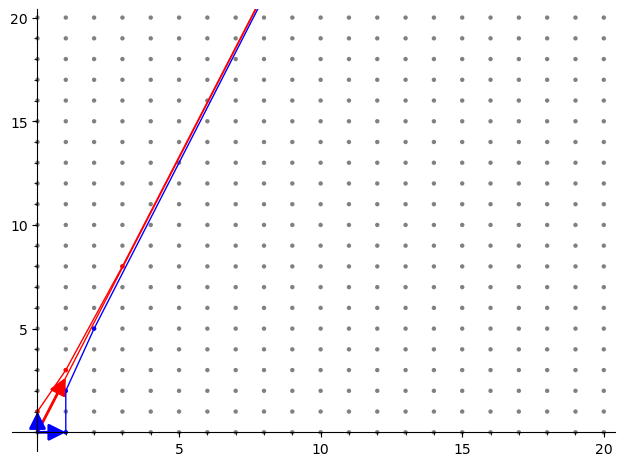

In [8]:
plot_size = 20

alpha = sqrt(7)
cf = continued_fraction(alpha)
terms = [cf[:i+1].value() for i in range(40)]
points = [(term.denominator(), term.numerator()) for term in terms]

basis = [(0, 1), (1, 0)]
points_even = [basis[1]] + points[0::2]
points_odd = [basis[0]] + points[1::2]
diff = basis + [(a[0] - b[0], a[1] - b[1]) for a, b in zip(points, points[1:])]

lattice = point([(x, y) for x in range(plot_size + 1) for y in range(plot_size + 1)], color='gray')
scene = [
    lattice,
    arrow((0, 0), (1, alpha), color='red'),
    plot(alpha * x, (x, 0, 10), color='red'),
    sum(arrow((0, 0), b, color='blue') for b in basis),
    point(points_odd, color='red'),
    line(points_odd, color='red'),
    point(points_even, color='blue'),
    line(points_even, color='blue'),
]

pretty_print(cf)
pretty_print([abs(det(matrix([odd, even]))) for even, odd in zip(diff[:], diff[1:])])
show(sum(scene), xmin=-0.5, xmax=plot_size, ymin=-0.5, ymax=plot_size)

In [9]:
plot_size = 10

alpha = sqrt(5)
cf = continued_fraction(alpha)
terms = [cf[:i+1].value() for i in range(40)]
points = [(term.denominator(), term.numerator()) for term in terms]

basis = [(0, 1), (1, 0)]
points_even = [basis[1]] + points[0::2]
points_odd = [basis[0]] + points[1::2]

lattice = point([(x, y) for x in range(plot_size + 1) for y in range(plot_size + 1)], color='gray')
lattice2 = point([(x, y * alpha) for x in range(plot_size + 1) for y in range(plot_size + 1)], color='red')
scene = [
    lattice,
    #lattice2,
    arrow((0, 0), (1, alpha), color='red'),
    plot(x * alpha, (x, 0, 10), color='red'),
    sum(arrow((0, 0), b, color='blue') for b in basis),
    implicit_plot(x^2 - (1/alpha * y)^2 == 1, (x, 0, plot_size), (y, 0, plot_size)),
    implicit_plot(-x^2 + (1/alpha * y)^2 == 1, (x, 0, plot_size), (y, 0, plot_size)),
]

pretty_print(cf)
show(sum(scene), xmin=-0.5, xmax=plot_size, ymin=-0.5, ymax=plot_size, gridlines=1/2)

NameError: name 'y' is not defined

In [ ]:
x, y = var('x, y')

show(lattice + implicit_plot(sqrt(1/2*(x^2 - 1)) == y, (x, 0, 10), (y, 0, 10)),
     xmin=-5, ymin=-5, xmax=5, ymax=5)

In [ ]:
def pivot_poly(p, *zs):
    C, B, A = p.list()
    for z in zs:
        A, B, C = A*z^2 + B*z + C, 2*A*z + B, A
    return A*x^2 + B*x + C

p = pivot_poly(x^2 - 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)
p.list(), p.roots()

# Equal Distance between Neighbors

The first polynomial is the "neighbor" polynomial, which is derived from the following equation:
$$
  x_1 = \frac{x_2}{x_1} - 1 = \dots = \frac{x_d}{x_{d-1}} - 1 = \frac{1}{x_d} - 1.
$$
This results in the equation
$$
  x_d^{d+1} + x_d - 1 = 0, \quad x_i = x_d^{d + 1 - i}
$$

In [ ]:
def neighbor_distance(xs):
    dist = []
    for x, y in zip([*xs, 1], [1, *xs]):
        if y == 0 or x == 0:
            dist.append(1)
        else:
            dist.append(frac(x / y))
    return dist

def distance_matrix(xs):
    D = [[0 for _ in xs] for _ in xs]
    for i, x in enumerate(xs):
        for j, y in enumerate(xs):
            if x == 0 or y == 0:
                D[i][j] = 1
            elif i == j:
                D[i][j] = frac(1 / x)
            else:
                D[i][j] = frac(x / y)
    return D

def real_distance_matrix(xs):
    dist = distance_matrix(xs)
    return [[RR(d) for d in row] for row in dist]

# Indices are zero-based. An index of -1 indicates selecting nothing in the first iteration and selecting 0 in the next iteration.
# Similarly, d - 1 indicates selecting d - 1 in the first iteration and nothing in the next iteration.
def select(xs):
    min_index = None
    min_dist = 1
    for i, dist in enumerate(neighbor_distance(xs)):
        if min_dist > dist:
            min_dist = dist
            min_index = i - 1
    return min_index

In [ ]:
def neighbor_poly(d):
    return x ** (d+1) + x - 1
neighbor_poly(5)

The polynomial gives us the field $\mathbb{Q}/ (x^{d+1} + x - 1)$.

In [ ]:
d = 3
p = neighbor_poly(d)
K.<psi> = NumberField(p, embedding=RR(0.5))
K

For our input, we choose $x_i = \psi^{d+1-i}$.

In [ ]:
xs = tuple(sorted([psi^(d+1-i) for i in range(1,d+1)]))

table([(i, x,RR(x)) for i, x in enumerate(xs)], header_row=[r'$i$', r'$x_i$'])

The distance between neighbors is indeed the same.

In [ ]:
dist = neighbor_distance(xs)

table([dist, [round(RR(d), 3) for d in dist]])

Therefore, we can expect a decrease of at least $\psi^3$ over two iterations. However, this condition does not hold up after those two iterations when choosing any element to pivot with. It only holds up if we choose the maximum $x_d$ of those elements. Choosing any other pivot, destroys this solution.

In [ ]:
n = 50
d = len(xs)

ys = xs
rows = [[
    *[f'$x_{i+1}$' for i in range(d)], 
    *[fr'$\{{x_{{{i+2}}}/x_{{{i+1}}}\}}$' for i in range(-1, d)], 
    r'$\ell_1$', 
    r'$\ell_2$',
]]

for i in range(n):
    # select pivot
    l = select(ys)
    
    # Add row to the output
    dist   = [round(RR(d), 3) for d in neighbor_distance(ys)]
    values = [round(RR(y), 3) for y in ys]
    rows.append([*values, *dist, '-' if l == -1 else l, '-' if l == d - 1 else l + 1])

    # pivot
    if l == -1:
        ys, _ = pivot(ys, 0)
    elif l == d - 1:
        ys, _ = pivot(ys, d - 1)
    else:
        ys, _ = pivot(ys, l, l + 1)
    
table(rows, header_row=True, align='center')

## Other polynomials

$$
    x^{d+1} + \sum_{k=1}^d k x^{d-k} = 1
$$

In [ ]:
xs = (1, 4^(1/3), 16^(1/3))
indices = [1, 2] + [2]*20
table([[RR(x) for x in pivot(xs, *indices[:i+1])] for i in range(len(indices))])

# $d$-bonacci Numbers


In [ ]:
def nbonacci_poly(d):
    i = var('i')
    return x^(d+1) + sum(x^i, i, 1, d) - 1
nbonacci_poly(3), *[r[0] for r in nbonacci_poly(1).roots()]

In [ ]:
y = polygen(RR, 'y')
d = 5

p = nbonacci_poly(d)
psi_real = find_root(p, 0, 1)
K.<psi> = NumberField(p, embedding=RR(psi_real))

In [ ]:
xs = tuple(sum(psi^i for i in range(1, k+1)) for k in range(1, d + 1))
xs

In [ ]:
ys = pivot(xs, 0)
argmin(ys), ys

In [ ]:
q = factor(-x^6 * p(x=1/x))
phi_real = find_root(q, 1, 2)
L.<phi> = NumberField(q, embedding=RR(phi_real))
q.list()

# Worst-Case Analysis

In [ ]:
d = 3
xs = tuple(i / (d + 1) for i in range(1, d + 1))
pivot(xs, 0)

In [ ]:
def unpivot(y, values, indices):
    for a, l in zip(values, indices):
        x = [0] * len(ys)
        for i, (yi, ai) in enumerate(zip(y, a)):
            if i == l:
                x[i] = frac(1 / (ai + yi))
            else:
                x[i] = frac((ai + yi) / (a[l] + y[l]))
        y = x
    return y

In [ ]:
ys = tuple(sorted(unpivot(xs, [(2, 1, 1)] * 5, [0] * 5)))
table(distance_matrix(ys), header_row=ys, header_column=['', *ys])

In [ ]:
pivot(ys, 0, 1, 2)

In [ ]:
K.<phi> = NumberField(x^3 - x - 1, embedding=RR(2))
psi = 1/phi

A = matrix([[1, phi, phi^2], [1, -psi]]).transpose()
b = vector([1, 1])
xs = A.solve_right(b)
pivot(xs, 1, 1, *[1]*10)

In [ ]:
def min_pivot(xs, n):
    coeffs = []
    for _ in range(n):
        l = None
        for i, xi in enumerate(xs):
            if (l is None or frac(xs[l]) > frac(xi)) and frac(xi) != 0:
                l = i
        if l is None:
            break
            
        xs, c = pivot(xs, l)
        coeffs += c
    return xs, coeffs